# SLU15 - Feature Engineering (aka Real World Data): Exercises notebook

## 1 About the data

In this exercise we will be using a dataset with Google Play Store apps, adapted from [here](https://www.kaggle.com/lava18/google-play-store-apps).

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('data/googleplaystore.csv')
data.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19,"10,000",Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14,"500,000",Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7,"5,000,000",Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25,"50,000,000",Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8,"100,000",Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


The fields in this dataset have the following meaning:
* **App** - name of the app.
* **Category** - category the app belongs to.
* **Rating** - overall user rating of the app (as when scraped).
* **Reviews** - number of user reviews for the app (as when scraped).
* **Size** - size of the app in MB (as when scraped).
* **Installs** - Number of user installs for the app (as when scraped).
* **Type** - Paid or Free.
* **Price** - price of the app (as when scraped).
* **Content Rating** - age group the app is targeted at: Children / Mature 21+ / Adult.
* **Genre** - an app can belong to multiple genres (apart from its main category).
* **Last Updated** - date when the app was last updated on Play Store (as when scraped).
* **Current Ver** - current version of the app available on Play Store (as when scraped).
* **Android Ver** - min required Android version (as when scraped).

The first thing we want to do is to check the dtypes of our features.

In [2]:
data.dtypes

App                object
Category           object
Rating            float64
Reviews             int64
Size               object
Installs           object
Type               object
Price             float64
Content Rating     object
Genres             object
Last Updated       object
Current Ver        object
Android Ver        object
dtype: object

## 2 Category dtype in pandas

### Exercise 1: Convert fields into category dtype (graded)

The fields `Category` and `Content Rating` are of dtype `object` but can be converted into dtype `category`, as explained in the Learning Notebook. Moreover:
* `Category` is a *nominal* categorical field, that is, without any meaningful order;
* `Content Rating` is an *ordinal* categorical field, as its values has a natural order.

In the following exercise, convert both fields into dtype `category` and, in the case of the field `Content Rating`, assign a natural order for its categories.

_Note:_ Regarding the "natural order" for the field `Content Rating`, go from less restrictive to more restrictive. If a given category does not fit, leave it to the end of the ordering. 

In [64]:
def convert_categorical_features(X, nominal_feat='Category', ordinal_feat='Content Rating'):

    X_s = X.copy()
    
    ## convert nominal feature to dtype 'category'
    # ...
    ## create list of ordered categories for ordinal feature
    # ordered_cats = ...
    ## convert ordinal feature to dtype 'category'
    # ...
    ## Assign natural order to ordinal feature
    # ...
    
    # YOUR CODE HERE
    
     ## feature 'category'
    X_s = X_s.assign(Category=X['Category'].astype('category'))
    
    X_s.describe(include='category')
    
    ## feature 'Content Rating'  
    ordered_cats = ['Everyone', 'Teen', 'Everyone 10+', 'Mature 17+', 'Adults only 18+', 'Unrated']
    
    X_s['Content Rating'] = (X['Content Rating'].astype('category'))
    
    X_s['Content Rating']  = X_s['Content Rating'].cat.set_categories(ordered_cats, ordered=True)

    
    return X_s




In [65]:
"""Check that the solution is correct."""
X_cat_conv = convert_categorical_features(data)

assert X_cat_conv['Category'].dtype == 'category'
assert X_cat_conv['Content Rating'].dtype == 'category'
assert X_cat_conv['Content Rating'].min() == 'Everyone'
assert X_cat_conv['Content Rating'].max() == 'Unrated'

### Exercise 2: Encode binary field (graded)

In this exercise, encode the target variable to be `1` when an app is `Paid` and to `0` when it is `Free` using the `map` method.

In [134]:
def encode_binary_field(f):

    f_e = f.copy()
    
    ## create a dictionary mapping the current values to int values
    # enconding_map = ...
    ## change target using the mapping
    # f_e = ...
    
    # YOUR CODE HERE
    # save column as a dataframe, as required by the transformer
    enconding_map = {'Paid': 1, 'Free': 0}

    f_e = f_e.map(enconding_map)

    return f_e
     
f_encoded = encode_binary_field(data.Type)

In [135]:
"""Check that the solution is correct."""
f_encoded = encode_binary_field(data.Type)

assert f_encoded[123] == 0
assert f_encoded[995] == 1
assert sum(f_encoded.fillna(0)) == 800

### Exercise 3: Discretize `Reviews` field (graded)

The field `Reviews` is a continuous field, with a distribution which is, not surprisingly, very skewed to the right (remember *skewness* from SLU04?).

The field 'Reviews' ranges from 0 to 78158306


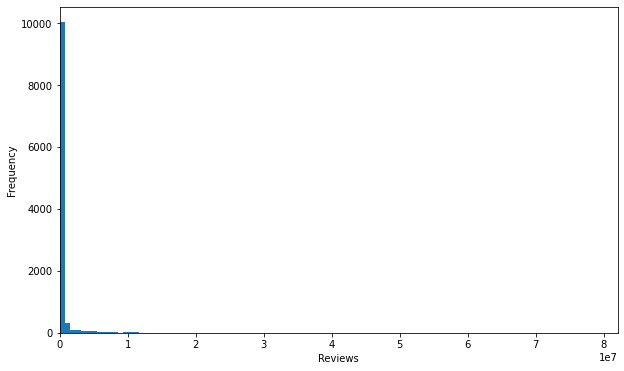

In [9]:
data.Reviews.plot.hist(bins=100, figsize=(10,6));
plt.xlim(0);
plt.xlabel('Reviews');
print("The field 'Reviews' ranges from", data.Reviews.min(), "to", data.Reviews.max())

We will deal with the skewness in a bit. Let's first discretize this field in two ways:
* create a new field called `discrete_reviews` which is the discretization of the `Review` field, such that the range is between 0 and 99 and the original instances are uniformly distributed;
* create a new field called `binary_reviews` which is the binarization of the `Review` field, such that amounts smaller than `100000` become `0` and amounts equal or greater than `100000` become 1.

Use `sklearn` transformers in this exercise.

In [12]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import Binarizer

def discretize_reviews(X):

    X_a = X.copy()
    
    ## create new column `discrete_amount` using suitable transformer
    # discretizer = ...
    # ...
    ## create new column `binary_amount` using suitable transformer
    # binarizer = ...
    # ...
    
    # YOUR CODE HERE
    data_to_scale
    
    return X_a

In [13]:
"""Check that the solution is correct."""
X_reviews = discretize_reviews(data)

assert X_reviews.discrete_reviews.nunique() == 32
assert X_reviews.discrete_reviews.max() == 99
assert X_reviews.loc[123, 'discrete_reviews'] == 0
assert X_reviews.binary_reviews.nunique() == 2
assert X_reviews.binary_reviews.max() == 1
assert X_reviews.loc[123, 'binary_reviews'] == 0

KeyError: "None of [Index(['Review'], dtype='object')] are in the [columns]"

Check the distribution of the two new fields you just calculated:

In [ ]:
X_reviews.discrete_reviews.plot.hist(bins=100, figsize=(10,6));
plt.xlim(0,99);
plt.xlabel('discrete_reviews');
plt.title('Reviews after discretization');

In [ ]:
X_reviews.binary_reviews.plot.hist(figsize=(4,4));
plt.xlim(0,1);
plt.xlabel('binary_reviews');
plt.title('Reviews after binarization');

### Exercise 4: Scale `Reviews` field (graded)

In the Learning Notebook, you also learned that numerical data can be scaled. 

In this exercise, let's scale the field `Reviews` in three different ways and compare the results:
* create a new field called `minmaxscaled_reviews` which scales uniformly the `Reviews` field such that the values range from 0 to 1;
* create a new field called `standardscaled_reviews` which scales the `Reviews` field such that the *mean* is 0 and the standard deviation is 1;
* create a new field called `robustscaled_reviews` which scales the `Reviews` field such that the *median* is 0 and it is scaled according to the Interquartile Range.

In [88]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

def scale_reviews(X):

    X_s = X.copy()
    
    ## create new column `minmaxscaled_reviews` using suitable transformer
    # ...
    ## create new column `standardscaled_reviews` using suitable transformer
    # ...
    ## create new column `robustscaled_reviews` using suitable transformer
    # ...
    
    # YOUR CODE HERE
    
    # Data to Scale _____________________________________________
    
    data_to_scale = X[['Reviews']]
    
    
    # MinMax Scaled________________________________________________
    
    # initialize transformer with desired options
    minmaxscaler = MinMaxScaler(feature_range=(0,1))

    # fit transformer to data
    minmaxscaler.fit(data_to_scale)

    # create new feature by transforming the data
    X['minmaxscaled_reviews'] = minmaxscaler.transform(data_to_scale)

    
    
    # Standard Scaled_______________________________________________
    
    standardscaler = StandardScaler()

    # fit transformer to data
    standardscaler.fit(data_to_scale)

    # create new feature by transforming the data
    X['standardscaled_reviews'] = standardscaler.transform(data_to_scale)
   
    # Robust Scaled_______________________________________________


    robustscaler = RobustScaler()


    # fit transformer to data
    robustscaler.fit(data_to_scale)

    # create new feature by transforming the data
    X['robustscaled_reviews'] = robustscaler.transform(data_to_scale)
    
    return X_s

In [89]:
"""Check that the solution is correct."""
X_scaled = scale_reviews(data)

assert X_scaled.minmaxscaled_reviews.min() == 0
assert X_scaled.minmaxscaled_reviews.max() == 1
assert math.isclose(X_scaled.minmaxscaled_reviews.mean(), 0.0057, abs_tol = 0.0001)
assert math.isclose(X_scaled.loc[1234, 'minmaxscaled_reviews'], 0.00022, abs_tol = 0.00001)
assert math.isclose(X_scaled.standardscaled_reviews.min(), -0.152, abs_tol = 0.001)
assert math.isclose(X_scaled.standardscaled_reviews.max(), 26.55, abs_tol = 0.01)
assert math.isclose(X_scaled.standardscaled_reviews.mean(), -5.244e-18, abs_tol = 0.01e-18)
assert math.isclose(X_scaled.loc[1234, 'standardscaled_reviews'], -0.146, abs_tol = 0.01)
assert math.isclose(X_scaled.robustscaled_reviews.min(), -0.0383, abs_tol = 0.0001)
assert math.isclose(X_scaled.robustscaled_reviews.max(), 1427.84, abs_tol = 0.01)
assert math.isclose(X_scaled.robustscaled_reviews.mean(), 8.076, abs_tol = 0.001)
assert math.isclose(X_scaled.loc[1234, 'robustscaled_reviews'], 0.274, abs_tol = 0.001)

Plot the distributions for the new fields you just calculated:

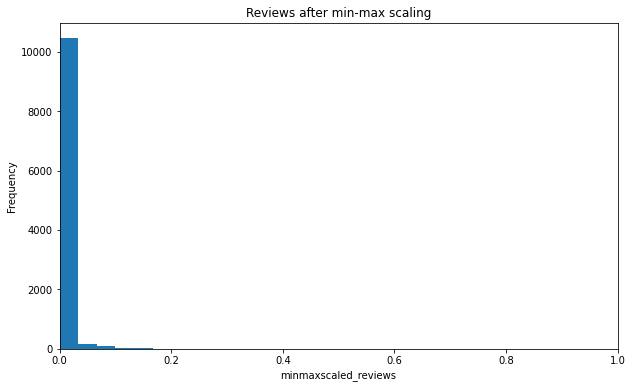

In [90]:
X_scaled.minmaxscaled_reviews.plot.hist(bins=30, figsize=(10,6));
plt.xlim(0,1);
plt.xlabel('minmaxscaled_reviews');
plt.title('Reviews after min-max scaling');

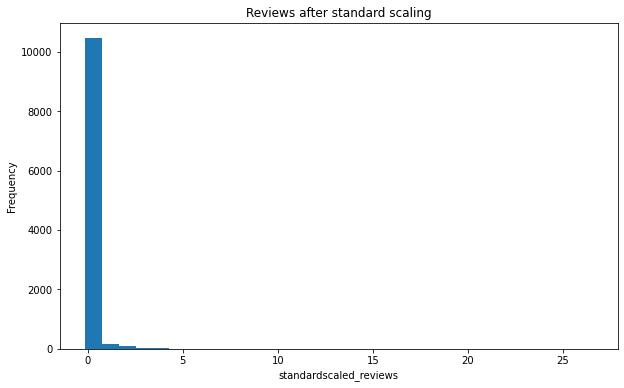

In [91]:
X_scaled.standardscaled_reviews.plot.hist(bins=30, figsize=(10,6));
plt.xlabel('standardscaled_reviews');
plt.title('Reviews after standard scaling');

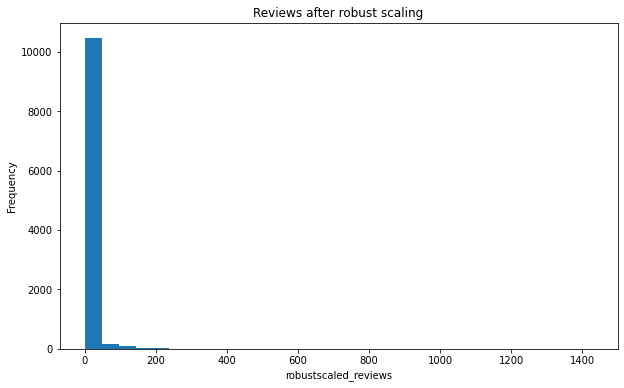

In [92]:
X_scaled.robustscaled_reviews.plot.hist(bins=30, figsize=(10,6));
plt.xlabel('robustscaled_reviews');
plt.title('Reviews after robust scaling');

### Exercise 5: Ordinal encode `Content Rating` feature

Finally, let's deal with the categorical features.

First, create a new field called `content_rating_encoded` which is the result of ordinal encoding of the `Content Rating` feature.

In [93]:
import category_encoders as ce

def encode_content_rating(X):

    X_r = X.copy()
    
    # create new column using suitable transformer
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return X_r

In [94]:
"""Check that the solution is correct."""
X_content_rating = encode_content_rating(data)

assert X_content_rating.content_rating_encoded.dtype == int
assert X_content_rating.content_rating_encoded.min() == 1
assert X_content_rating.content_rating_encoded.max() == 6
assert X_content_rating.loc[1234, 'content_rating_encoded'] == 1

NotImplementedError: 

### Exercise 6: One-hot encode type feature

Finally, perform a one-hot encoding of the `Category` feature. Pay attention to the following points:
* return the original DataFrame `X`, but with the `Category` feature replaced by the new ones resulting from the one-hot encoding;
* make sure the new features have names of the form `Category_<value>`, where `<value>` is the category being indicated by that feature.

In [ ]:
def encode_category(X):

    X_t = X.copy()
    
    # perform one-hot encoding in X_t
    # YOUR CODE HERE
    raise NotImplementedError()
    
    return X_t

In [ ]:
"""Check that the solution is correct."""
X_category = encode_category(data)

assert X_category.shape[1] > 10
assert X_category.Category_WEATHER.sum() == 82
assert X_category['Category_-1'].sum() == 0
assert X_category.loc[1234, 'Category_VIDEO_PLAYERS'] == 0
assert X_category.loc[4322, 'Category_SHOPPING'] == 1